# Import Required Libraries

## Environment Setup

In [1]:
import os
import random
import re
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import shutil

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image

from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

2025-11-09 16:43:50.009880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762706630.032058     204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762706630.038720     204 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Detected: {gpus[0].name}")
    print("    Type:", tf.config.experimental.get_device_details(gpus[0]).get('device_name', 'Unknown'))
else:
    print("No GPU detected — switch to GPU runtime in Kaggle.")

# Quick GPU test (optional)
try:
    with tf.device('/GPU:0'):
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        c = tf.matmul(a, b)
    print("GPU computation successful.")
except Exception as e:
    print("GPU test failed:", e)

TensorFlow version: 2.18.0
GPU Detected: /physical_device:GPU:0
    Type: Tesla T4
GPU computation successful.


I0000 00:00:1762706635.044110     204 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762706635.044815     204 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data Extraction

**What is this doing here?**  
- This step recursively searches through the main dataset directories (like `coral_images_dry` and `coral_images_wet`) to locate all image files (`.jpg`, `.png`) present in every nested subfolder.  
- It uses functions such as `rglob` to ensure that no image is missed, regardless of how deep it is inside the folder hierarchy.

**Purpose of the same?**  
- To confirm the total number of images in the dataset and validate that each source (dry or wet) contains the expected amount of data.  
- This also helps identify structural inconsistencies like missing subfolders, misnamed files, or unbalanced sample counts.

**Why are we doing this?**  
- Because coral datasets are usually collected from multiple surveys or camera deployments, the directory organization can vary.  
- A recursive check ensures all images are accessible and uniformly referenced before creating metadata or performing feature extraction.  
- This step ensures dataset completeness and correctness before proceeding to preprocessing or training.


In [3]:
dry_root = Path('/kaggle/input/coral-condition-dataset/coral_images_dry')
wet_root = Path('/kaggle/input/coral-condition-dataset/coral_images_wet')

***Sampling and Sanity Checking (`sample_info` function):***

**What is this doing here?**  
- The function `sample_info` recursively searches within the given `root` directory for all `.jpg` and `.png` images using `Path.rglob()`.  
- It prints the total image count found under that root and returns:
    - `files`: the complete list of image file paths, and  
    - `samples`: a small random subset (default 5) for quick inspection.

**Purpose of the same?**  
- To perform a quick **integrity and sanity check** before deeper processing.  
- It helps verify that:
    - Images are actually being detected,  
    - The recursive search pattern works across nested folders, and  
    - Paths are valid (no broken or missing references).  

By reviewing the printed output or sampled file paths, we can confirm that both `dry_root` and `wet_root` are properly loaded.

**Why are we doing this?**  
- In datasets with complex folder hierarchies (like coral imagery), verifying early that all image paths are accessible and correctly captured avoids downstream errors during feature extraction or clustering.  
- It ensures our directory scanning logic works uniformly for both *dry* and *wet* image sets, even if subfolder depths differ.

**Additional note:**  
- This function is generic - it doesn’t assume any fixed folder structure.  
- Because it uses `rglob()`, it can traverse arbitrary nesting levels such as:
```
root/
 ├── folder1/
 │   ├── 1.jpg
 │   ├── 2.jpg
 ├── 3.jpg
 ├── 4.jpg
```
All 4 images above will be correctly detected, regardless of where they’re located within `root`.


In [4]:
def sample_info(root, n=5):
    files = list(root.rglob('*.jpg')) + list(root.rglob('*.png'))
    print(f"{root.name}: {len(files)} images")
    samples = random.sample(files, min(n, len(files)))
    return files, samples

In [5]:
dry_files, dry_samples = sample_info(dry_root)
wet_files, wet_samples = sample_info(wet_root)

coral_images_dry: 26300 images
coral_images_wet: 12744 images


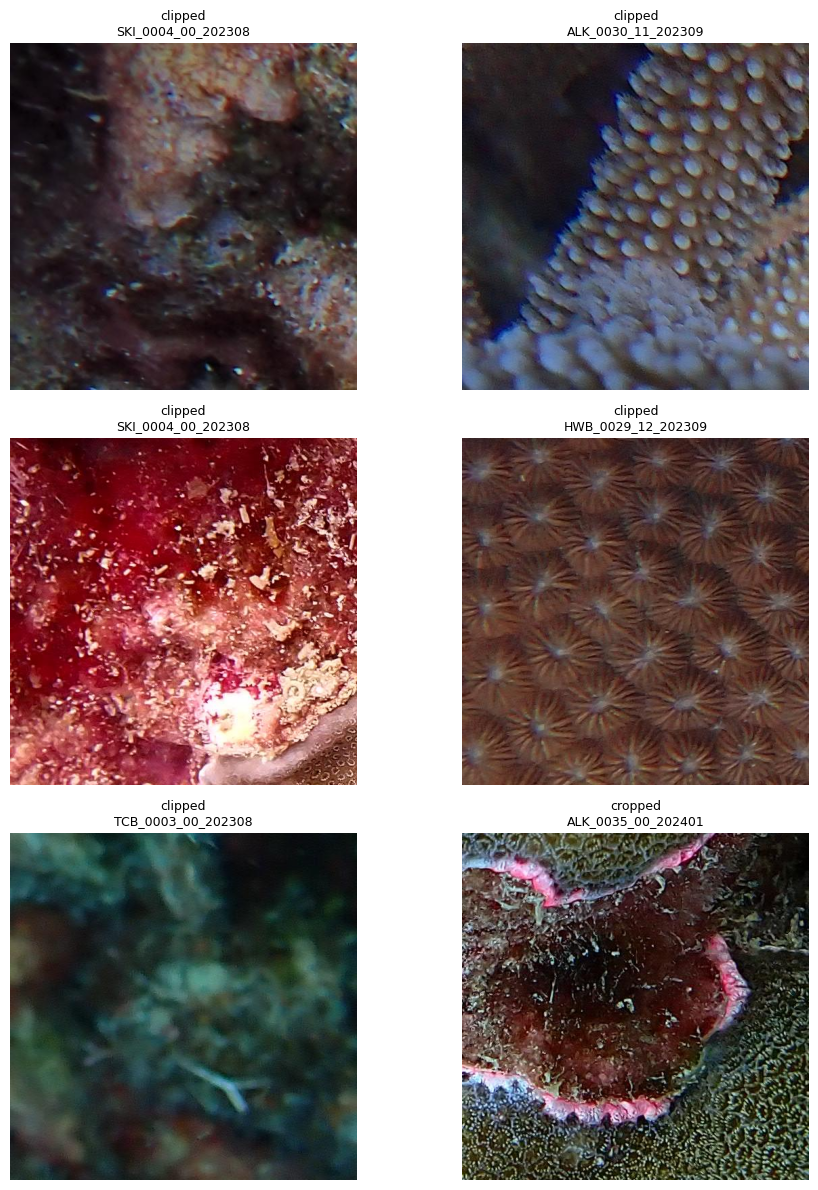

In [6]:
# Combine a few samples
samples = (dry_samples + wet_samples)[:6]

# Plot 2 images per row
rows = (len(samples) + 1) // 2
plt.figure(figsize=(10, rows * 4))

for i, p in enumerate(samples):
    plt.subplot(rows, 2, i + 1)
    img = Image.open(p).convert('RGB')
    plt.imshow(img)
    plt.title(f"{p.parent.name}\n{p.name[:18]}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing

***Directory Structure Inspection and Metadata Creation:***

**What is this doing here?**  
- The code recursively lists the folder contents up to three levels deep using nested loops with `Path.glob('*')`.  
- It prints each directory and its immediate subdirectories/files in a tree-like format to visually confirm how data is organized under `dry_root` and `wet_root`.  

For example:
```
coral_images_dry/
 ├── coral_images/
 │   ├── 20230919_SWP/
 │   │   ├── clipped/
 │   │   ├── cropped/
 │   │   ├── *.jpg
```

**Purpose of the same?**  
- To inspect and understand the dataset hierarchy before programmatically building metadata.  
Coral datasets often contain nested structures like `survey_folder -> subfolder (clipped/cropped/original) -> images`.  
- Seeing this helps verify that all expected categories or survey folders exist and are organized consistently.

**Why are we doing this?**  
- Knowing the exact folder layout ensures we extract metadata correctly — such as identifying which level corresponds to the *survey folder*, which subfolder holds *clipped or cropped* images, and how to tag them with their *source* (dry/wet).  
- If this structure isn’t confirmed, metadata generation could mislabel paths or duplicate entries.

**Metadata creation logic:**  
- After confirming the structure, a metadata DataFrame (`metadata.csv`) is created.  
- For each image path found under dry/wet roots:
    - `image_path`: the absolute path to the image.  
    - `filename`: extracted using `os.path.basename(path)`.  
    - `folder`: usually the survey folder (like `20230919_SWP`) or subfolder name if it’s within `clipped/` or `cropped/`.  
    - `source`: labeled as `dry` or `wet` depending on which root it came from.  

This structured metadata allows seamless merging, filtering, and grouping operations for EDA and later modeling.

**Additional context:**  
- The metadata file (`metadata.csv`) becomes the backbone of the dataset — linking every image to its contextual attributes (survey, condition, and source).  
- It replaces manual directory navigation and supports downstream tasks like balanced sampling, feature extraction, and visualization.


In [7]:
# show 3 levels of directory contents
for root in [dry_root, wet_root]:
    print(f"\n\n\nListing under: {root}")
    for p in list(root.glob('*')):
        print(" ├──", p)
        if p.is_dir():
            for q in list(p.glob('*')):
                print(" │   ├──", q)
                if q.is_dir():
                    for r in list(q.glob('*')):
                        print(" │   ├──", r)




Listing under: /kaggle/input/coral-condition-dataset/coral_images_dry
 ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images
 │   ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images/20230919_SWP
 │   ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images/20230919_SWP/SWP_0025_00_20230919_0020.jpg
 │   ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images/20230919_SWP/SWP_0025_00_20230919_0001.jpg
 │   ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images/20230919_SWP/SWP_0025_00_20230919_0031.jpg
 │   ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images/20230919_SWP/SWP_0025_00_20230919_0022.jpg
 │   ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images/20230919_SWP/SWP_0025_00_20230919_0029.jpg
 │   ├── /kaggle/input/coral-condition-dataset/coral_images_dry/coral_images/20230919_SWP/SWP_0025_00_20230919_0036.jpg
 │   ├── /kaggle/input/coral-condition-datas

In [8]:
def build_metadata(root_paths, out_csv='/kaggle/working/metadata.csv'):
    rows = []
    for source, root in root_paths.items():
        all_files = list(root.rglob('*.jpg')) 
        print(f"{source}: found {len(all_files)} images under {root}")
        for p in all_files:
            rows.append({
                'image_path': str(p),
                'filename': p.name,
                'folder': p.parent.name,
                'source': source
            })
    df = pd.DataFrame(rows)
    df.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv}, shape: {df.shape}")
    return df

In [9]:
df = build_metadata({'dry': dry_root, 'wet': wet_root})

dry: found 26300 images under /kaggle/input/coral-condition-dataset/coral_images_dry
wet: found 12744 images under /kaggle/input/coral-condition-dataset/coral_images_wet
Saved: /kaggle/working/metadata.csv, shape: (39044, 4)


In [10]:
df.sample(25)

image_path  \
24278  /kaggle/input/coral-condition-dataset/coral_im...   
15507  /kaggle/input/coral-condition-dataset/coral_im...   
31583  /kaggle/input/coral-condition-dataset/coral_im...   
17421  /kaggle/input/coral-condition-dataset/coral_im...   
12024  /kaggle/input/coral-condition-dataset/coral_im...   
14876  /kaggle/input/coral-condition-dataset/coral_im...   
22177  /kaggle/input/coral-condition-dataset/coral_im...   
3722   /kaggle/input/coral-condition-dataset/coral_im...   
16072  /kaggle/input/coral-condition-dataset/coral_im...   
24937  /kaggle/input/coral-condition-dataset/coral_im...   
27842  /kaggle/input/coral-condition-dataset/coral_im...   
5943   /kaggle/input/coral-condition-dataset/coral_im...   
34281  /kaggle/input/coral-condition-dataset/coral_im...   
37722  /kaggle/input/coral-condition-dataset/coral_im...   
33988  /kaggle/input/coral-condition-dataset/coral_im...   
24116  /kaggle/input/coral-condition-dataset/coral_im...   
22252  /kaggle/input/coral-condition-dataset/coral_im...   
12652  /kaggle/input/coral-condition-dataset/coral_im...   
18427  /kaggle/input/coral-condition-dataset/coral_im...   
34665  /kaggle/input/coral-condition-dataset/coral_im...   
14274  /kaggle/input/coral-condition-dataset/coral_im...   
18002  /kaggle/input/coral-condition-dataset/coral_im...   
23992  /kaggle/input/coral-condition-dataset/coral_im...   
27124  /kaggle/input/coral-condition-dataset/coral_im...   
26869  /kaggle/input/coral-condition-dataset/coral_im...   

                               filename   folder source  
24278  TCB_0003_00_20230816_0100_31.jpg  clipped    dry  
15507  SKI_0004_00_20230817_0095_26.jpg  clipped    dry  
31583  ALK_0035_00_20240118_0053_12.jpg  cropped    wet  
17421  SKI_0004_00_20230817_0028_26.jpg  clipped    dry  
12024  HNM_0031_00_20230928_0003_10.jpg  clipped    dry  
14876  TTB_0002_00_20230815_0014_25.jpg  clipped    dry  
22177  CBK_0001_00_20230804_0080_12.jpg  clipped    dry  
3722    ALK_0030_11_20230927_0075_3.jpg  clipped    dry  
16072  SKI_0004_00_20230817_0017_19.jpg  clipped    dry  
24937  TCB_0003_00_20230816_0022_25.jpg  clipped    dry  
27842  HWB_0037_12_20240122_0044_29.jpg  cropped    wet  
5943               20230412_0018_26.jpg  clipped    dry  
34281  CBK_0038_00_20240124_0018_24.jpg  cropped    wet  
37722  CBK_0039_00_20240126_0028_25.jpg  cropped    wet  
33988  CBK_0038_00_20240124_0042_12.jpg  cropped    wet  
24116   TCB_0003_00_20230816_0044_1.jpg  clipped    dry  
22252  CBK_0001_00_20230804_0056_15.jpg  clipped    dry  
12652   HNM_0031_00_20230928_0049_6.jpg  clipped    dry  
18427  SKI_0004_00_20230817_0079_34.jpg  clipped    dry  
34665  CBK_0038_00_20240124_0062_31.jpg  cropped    wet  
14274  AOM_0032_00_20230929_0003_23.jpg  clipped    dry  
18002  SKI_0004_00_20230817_0025_12.jpg  clipped    dry  
23992  TCB_0003_00_20230816_0048_10.jpg  clipped    dry  
27124  HWB_0037_12_20240122_0029_17.jpg  cropped    wet  
26869  HWB_0037_12_20240122_0024_24.jpg  cropped    wet

In [11]:
df['source'].value_counts()

source
dry    26300
wet    12744
Name: count, dtype: int64

In [12]:
df['folder'].value_counts()

folder
clipped                        25546
cropped                        12390
20230817_SKI                     143
20230926_HWB                     117
20230816_TCB                     110
20230928_HNM                     100
20230927_ALK                      84
20230804_CBK                      83
20240118_ALK_done                 74
20240122_HWB_done                 71
20240124_CBK_done                 69
20240129_SIN_done                 58
20230421_preliminary_survey       49
20240126_CBK_done                 41
20230919_SWP                      37
20240103_SKI_done                 27
20230929_AOM                      17
20230815_TTB                      14
20240119_SKI_done                 12
20240115_TCB_done                  2
Name: count, dtype: int64

# Build Labels for data

## Collect all the Dry and Wet Image Paths

In [13]:
# Collect all image paths
image_paths = list(dry_root.rglob('*.jpg')) + list(dry_root.rglob('*.png')) \
            + list(wet_root.rglob('*.jpg')) + list(wet_root.rglob('*.png'))

print(f"Total images found: {len(image_paths):,}")

Total images found: 39,044


## Extract Deep Features with EfficientNetB0

In [14]:
device_name = tf.test.gpu_device_name()
print("Using device:", device_name if device_name else "CPU")

Using device: /device:GPU:0


I0000 00:00:1762706783.380910     204 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762706783.381170     204 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


***Feature Extraction using EfficientNetB0:***

**What is this doing here?**  
- In this step, a **pre-trained EfficientNetB0** model (from ImageNet weights) is loaded to generate compact feature embeddings for each coral image.  
- Instead of training from scratch, the model acts as a **feature extractor** — it converts each input image into a high-dimensional vector (for example, a 1280-length embedding).  
- This is typically done by removing the final classification layer and using the output of the last global pooling layer as the feature representation.

**Purpose of the same?**  
- To numerically represent each coral image in a way that captures its **texture, color, and structural patterns**.  
- These embeddings allow downstream unsupervised methods (like clustering or visualization) to understand image similarities without labels.  
- It effectively transforms raw pixel data into semantically meaningful numerical features.

**Why are we doing this?**  
- Coral images are complex - differences between *healthy*, *bleached*, or *diseased* coral are subtle and spatially distributed.  
- Manually extracting these differences through handcrafted features (color histograms, SIFT, etc.) would be inefficient and less accurate.  
- By using a pre-trained EfficientNet, we leverage deep visual features learned from millions of natural images, which generalize well to coral textures.  
- This approach reduces computation, improves representation quality, and prepares the dataset for dimensionality reduction or clustering.

**Additional details:**  
- Each image is resized (usually to 224×224 pixels) and normalized before passing into the model.  
- The embeddings are often stored in a DataFrame or NumPy array alongside metadata (`image_path`, `folder`, `source`).  
- These features serve as input for later steps such as **PCA**, **t-SNE**, or **K-Means** for pattern discovery and visualization.


In [15]:
# Load pretrained EfficientNetB0 without top
model = EfficientNetB0(weights=None, include_top=False, pooling="avg")

In [16]:
# Feature Extraction Function
def extract_features(img_path, target_size=(224, 224)):
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [17]:
# Feature Extraction via Parallel Execution
def extract_features_parallel(image_paths, max_workers=8):
    features, valid_paths = [], []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_path = {executor.submit(extract_features, path): path for path in image_paths}
        for future in tqdm(as_completed(future_to_path), total=len(future_to_path), desc="Extracting features"):
            path = future_to_path[future]
            feat = future.result()
            if feat is not None:
                features.append(feat)
                valid_paths.append(str(path))
    return np.array(features), valid_paths

In [18]:
# Run the actual Feature Extraction in parallel

image_paths = df['image_path'].tolist()

features, valid_paths = extract_features_parallel(image_paths, max_workers=8)
print(f"Extracted feature vectors: {features.shape}")

Extracting features:   0%|          | 0/39044 [00:00<?, ?it/s]

I0000 00:00:1762706789.472577     255 service.cc:148] XLA service 0x7d9a0809be50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762706789.475086     255 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762706789.475107     255 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762706790.476896     255 cuda_dnn.cc:529] Loaded cuDNN version 90300


I0000 00:00:1762706794.642253     255 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Extracted feature vectors: (39044, 1280)


In [19]:
np.save('coral_features.npy', features)
pd.DataFrame({'image_path': valid_paths}).to_csv('valid_paths.csv', index=False)
print("Saved feature arrays and valid paths.")

Saved feature arrays and valid paths.


## Dimensionality Reduction

***Dimensionality Reduction using PCA and t-SNE:***

**What is this doing here?**  
- After generating high-dimensional feature embeddings (e.g., 1280 dimensions per image from EfficientNetB0), this step applies **Principal Component Analysis (PCA)** and **t-distributed Stochastic Neighbor Embedding (t-SNE)** to reduce these features into lower dimensions — typically 50D with PCA first, then 2D or 3D with t-SNE for visualization.

**Purpose of the same?**  
- To make complex, high-dimensional image data **interpretable and visualizable**.  
- PCA captures the most important variance directions in the data, while t-SNE emphasizes **local neighborhood structure**, revealing hidden clusters or relationships between coral images.  
- These plots help visually inspect if images group naturally based on coral type, health condition, or capture environment (dry vs. wet).

**Why are we doing this?**  
- High-dimensional embeddings are hard to interpret directly.  
- Reducing them to 2D/3D helps understand whether similar images (e.g., healthy vs. diseased coral) form distinct regions in feature space.  
- It validates if the extracted features contain enough discriminative information before training classification models.  
- Detecting outliers or overlapping clusters early can guide further data cleaning or model tuning.

**Additional details:**  
- PCA also helps **denoise** the embeddings by removing minor variance components.  
- t-SNE is computationally intensive, so PCA pre-reduction improves speed and stability.  
- The resulting 2D embeddings are usually visualized with seaborn or matplotlib scatter plots, colored by attributes like “folder”, “source”, or “cluster_id”.


In [20]:
# Standardize and apply PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(features_scaled)

print(f"PCA-reduced shape: {features_pca.shape}")

PCA-reduced shape: (39044, 50)


# Cluster the Images using K-Means Clustering

***Clustering and Unsupervised Pattern Discovery:***

**What is this doing here?**  
- After reducing the image embeddings (using PCA/t-SNE), this step applies **K-Means clustering** on the 50-dimensional PCA-reduced features to group similar coral images together.  

Example:
```python
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_pca)
```
- This assigns each image a `cluster` label (0–4) based on feature similarity.

**Purpose of the same?**  
- To uncover **distinct coral image groups** with similar visual and statistical properties — like color tone, lighting condition, texture, or coral health state — without manual labeling.  
- The model groups the data purely based on its learned embedding distribution from EfficientNet.

**Why are we doing this?**  
- It allows us to understand the **structure and diversity** of the coral dataset.  
- Identifies **patterns or categories** (e.g., bright healthy coral, dark stressed coral, algae-covered coral, etc.).  
- Helps detect **data imbalance or bias**, by showing which visual conditions dominate.  
- Enables **downstream labeling**, where clusters can later be mapped to coral health classes or conditions.

**What do the clusters represent?**  
Each cluster represents a **group of images sharing similar visual and feature characteristics**:
- **Cluster 0** – Corals with medium brightness and moderate saturation, possibly healthy or neutral lighting.  
- **Cluster 1** – Slightly brighter corals, potentially indicating lighter textures or clearer water conditions.  
- **Cluster 2** – Very bright, low-saturation corals — could correspond to bleached or overexposed regions.  
- **Cluster 3** – Moderately bright, low-saturation corals — possibly transitional or shaded corals.  
- **Cluster 4** – Dark and high-saturation images — could represent deeper, shadowed, or low-light coral images.

These inferences are drawn from both **feature space grouping** and **color-statistical analysis** in later steps.

**Why only 5 clusters (variables) if we have 8 originally?**  
- Although the **PCA reduced features** to 50 dimensions, K-Means only requires us to specify the number of **clusters**, not the number of variables.  
- Here, `k=5` means we expect **five visually distinct groups** in the data — a design choice based on:
    - Observed dataset variability.  
    - Practical interpretability (too many clusters cause redundancy).  
    - Empirical testing (the elbow or silhouette method may show that 5 is optimal).

In summary, while PCA compressed the *features* to 50 components, **K-Means with 5 clusters** divides the dataset into **five meaningful coral condition groups**.


In [21]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_pca)

# Build DataFrame
df_clusters = pd.DataFrame({
    'image_path': valid_paths,
    'cluster': clusters
})

df_clusters.to_csv('coral_clusters.csv', index=False)
print(df_clusters['cluster'].value_counts())

cluster
2    14780
0     9379
4     6925
3     5175
1     2785
Name: count, dtype: int64


## Visualize the formed Clusters using t-SNE

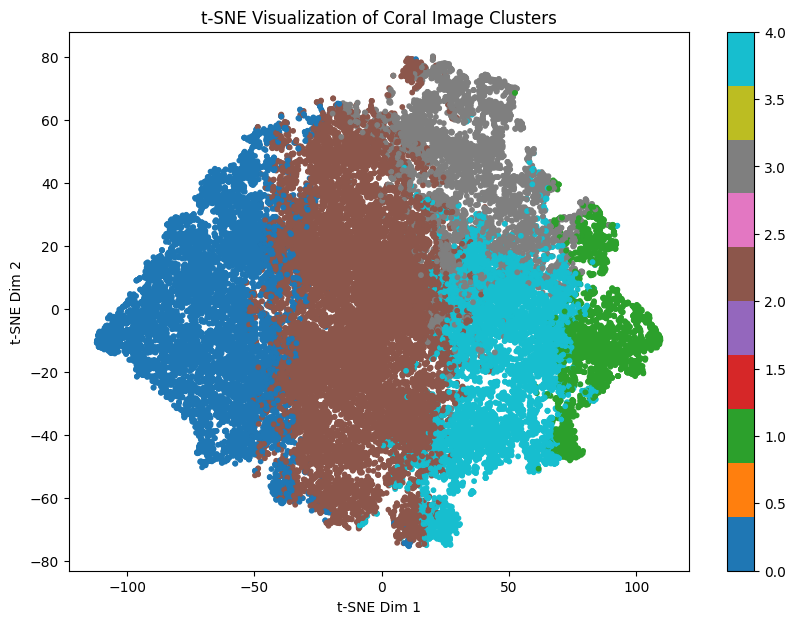

In [22]:
# TSNE visualization (may take time for large data)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features_pca)  # Limit for speed

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1],
                      c=clusters, cmap='tab10', s=10)
plt.title('t-SNE Visualization of Coral Image Clusters')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.colorbar(scatter)
plt.show()

## Display samples from each cluster

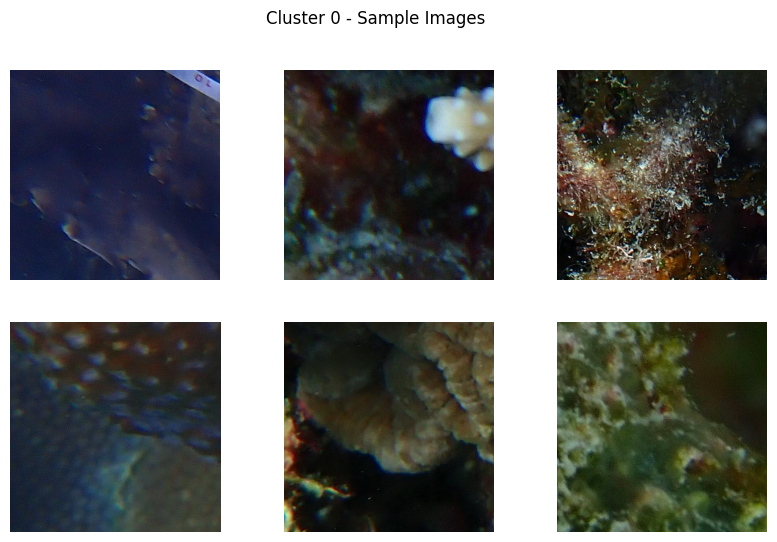

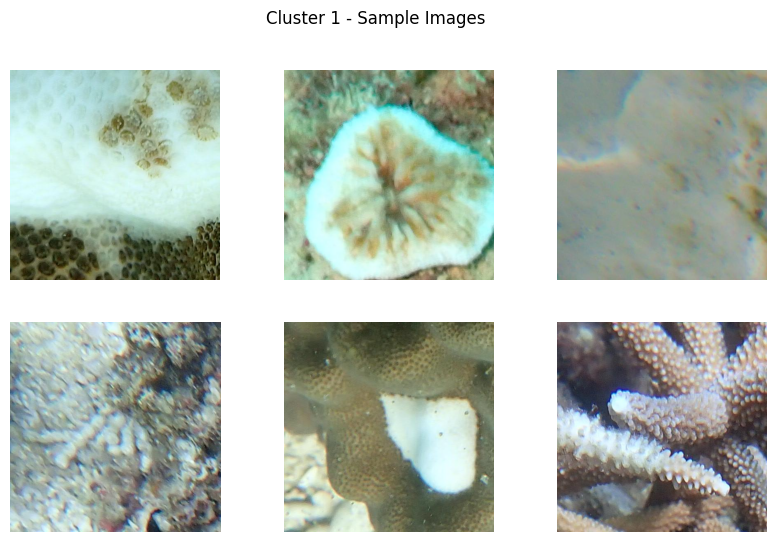

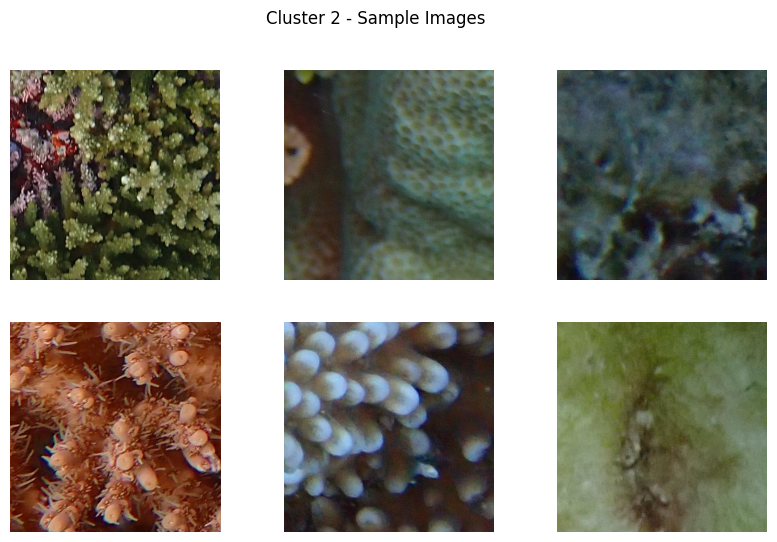

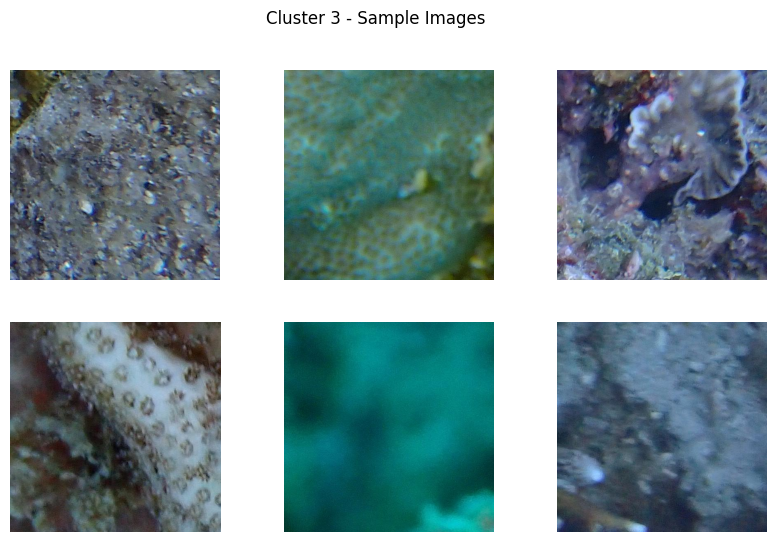

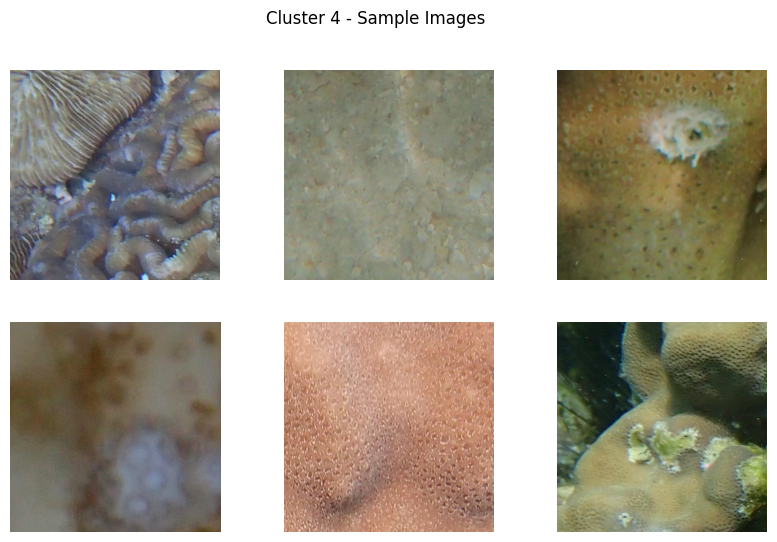

In [23]:
def show_cluster_samples(df, cluster_id, n=6):
    cluster_paths = df[df['cluster'] == cluster_id]['image_path'].sample(n, random_state=42).values
    plt.figure(figsize=(10, 6))
    for i, path in enumerate(cluster_paths):
        plt.subplot(2, 3, i+1)
        img = Image.open(path).convert('RGB')
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} - Sample Images")
    plt.show()

# Show 6 random images from each cluster
for c in sorted(df_clusters['cluster'].unique()):
    show_cluster_samples(df_clusters, c)

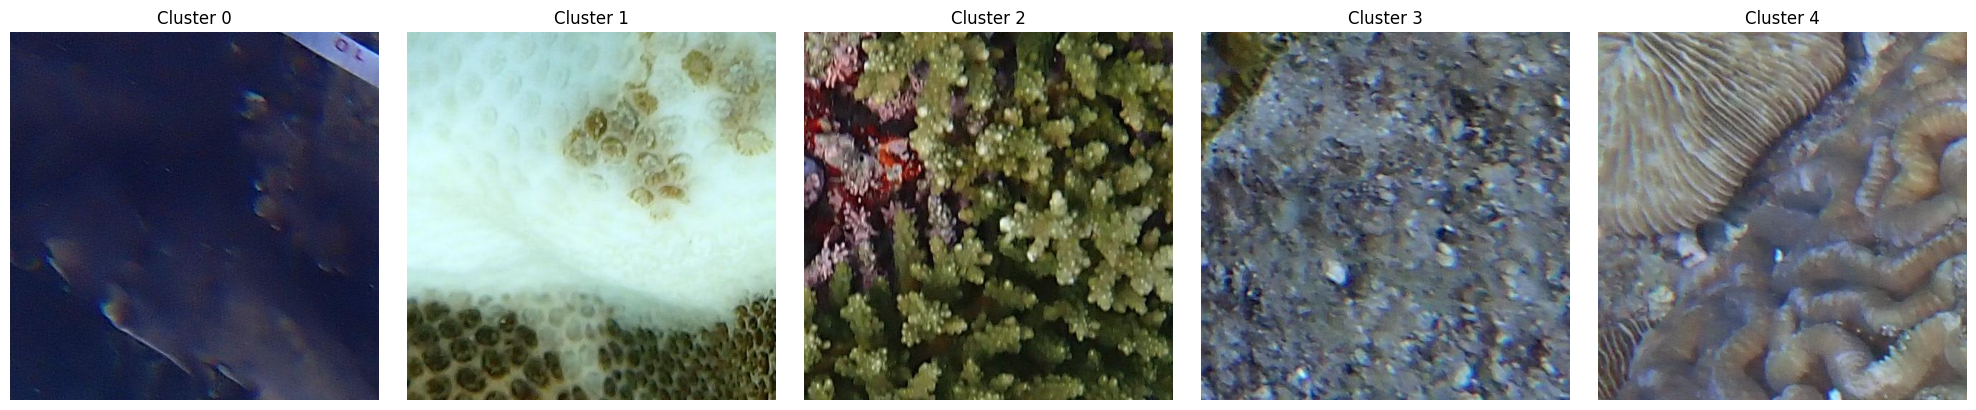

In [24]:
# Collect one random image per cluster
sample_images = []
for c in sorted(df_clusters['cluster'].unique()):
    path = df_clusters[df_clusters['cluster'] == c]['image_path'].sample(1, random_state=42).values[0]
    sample_images.append((c, path))

# Plot horizontally
plt.figure(figsize=(4 * len(sample_images), 4))
for i, (cluster_id, path) in enumerate(sample_images):
    img = Image.open(path).convert('RGB')
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Cluster {cluster_id}", fontsize=12)

plt.tight_layout()
plt.show()

In [26]:
# Function to compute image color/texture statistics
def image_stats(path):
    try:
        img = Image.open(path).convert('RGB')
        arr = np.array(img) / 255.0  # normalize to [0, 1]

        # Convert to HSV (OpenCV expects BGR)
        bgr = (arr[..., ::-1] * 255).astype('uint8')
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]

        # Compute brightness, saturation, and texture metrics
        mean_brightness = v.mean() / 255.0
        mean_saturation = s.mean() / 255.0
        lum = 0.2126 * arr[..., 0] + 0.7152 * arr[..., 1] + 0.0722 * arr[..., 2]
        lum_std = lum.std()

        return mean_brightness, mean_saturation, lum_std

    except Exception:
        # Skip unreadable images
        return np.nan, np.nan, np.nan


# Compute stats for *all images* in each cluster
cluster_metrics = []
for c in sorted(df_clusters['cluster'].unique()):
    print(f"\nProcessing Cluster {c} ...")
    paths = df_clusters[df_clusters['cluster'] == c]['image_path'].values

    brightness_list, sat_list, lumstd_list = [], [], []

    # tqdm progress bar for all images
    for p in tqdm(paths, desc=f"Cluster {c}", ncols=100):
        b, s, ls = image_stats(p)
        if not np.isnan(b):
            brightness_list.append(b)
            sat_list.append(s)
            lumstd_list.append(ls)

    # Calculate per-cluster averages
    cluster_metrics.append({
        'cluster': c,
        'n_images': len(brightness_list),
        'mean_brightness': np.mean(brightness_list),
        'mean_saturation': np.mean(sat_list),
        'mean_luminance_std': np.mean(lumstd_list)
    })


Processing Cluster 0 ...


Cluster 0:   0%|                                                           | 0/9379 [00:00<?, ?it/s]


Processing Cluster 1 ...


Cluster 1:   0%|                                                           | 0/2785 [00:00<?, ?it/s]


Processing Cluster 2 ...


Cluster 2:   0%|                                                          | 0/14780 [00:00<?, ?it/s]


Processing Cluster 3 ...


Cluster 3:   0%|                                                           | 0/5175 [00:00<?, ?it/s]


Processing Cluster 4 ...


Cluster 4:   0%|                                                           | 0/6925 [00:00<?, ?it/s]

In [27]:
# Create summary DataFrame
metrics_df = pd.DataFrame(cluster_metrics).sort_values('cluster')
print("\n=== Cluster Metrics Summary ===")
metrics_df


=== Cluster Metrics Summary ===
   cluster  n_images  mean_brightness  mean_saturation  mean_luminance_std
0        0      9379         0.213652         0.430153            0.107641
1        1      2785         0.666041         0.214853            0.140396
2        2     14780         0.346147         0.331251            0.143388
3        3      5175         0.439220         0.337231            0.129777
4        4      6925         0.498285         0.275200            0.147476


In [28]:
# Save for report/reference
metrics_df.to_csv('/kaggle/working/cluster_color_metrics.csv', index=False)
print("\nSaved to /kaggle/working/cluster_color_metrics.csv")


Saved to /kaggle/working/cluster_color_metrics.csv


In [29]:
# Paths
working = Path('/kaggle/working')
print("Files in /kaggle/working:")
print(list(working.glob('*')))

# Load saved outputs
clusters_fp = working / 'coral_clusters.csv'
metrics_fp = working / 'cluster_color_metrics.csv'
valid_paths_fp = working / 'valid_paths.csv'
features_fp = working / 'coral_features.npy'

print("Exists:", {str(p.name): p.exists() for p in [clusters_fp, metrics_fp, valid_paths_fp, features_fp]})

# Load key objects (if present)
if clusters_fp.exists():
    df_clusters = pd.read_csv(clusters_fp)
    print("df_clusters shape:", df_clusters.shape)
if metrics_fp.exists():
    metrics_df = pd.read_csv(metrics_fp)
    print("metrics_df:\n", metrics_df)
if valid_paths_fp.exists():
    valid_paths = pd.read_csv(valid_paths_fp)['image_path'].tolist()
    print("Valid paths:", len(valid_paths))
if features_fp.exists():
    features = np.load(features_fp)
    print("features shape:", features.shape)

Files in /kaggle/working:
[PosixPath('/kaggle/working/.virtual_documents'), PosixPath('/kaggle/working/metadata.csv'), PosixPath('/kaggle/working/coral_features.npy'), PosixPath('/kaggle/working/valid_paths.csv'), PosixPath('/kaggle/working/cluster_color_metrics.csv'), PosixPath('/kaggle/working/coral_clusters.csv')]
Exists: {'coral_clusters.csv': True, 'cluster_color_metrics.csv': True, 'valid_paths.csv': True, 'coral_features.npy': True}
df_clusters shape: (39044, 2)
metrics_df:
    cluster  n_images  mean_brightness  mean_saturation  mean_luminance_std
0        0      9379         0.213652         0.430153            0.107641
1        1      2785         0.666041         0.214853            0.140396
2        2     14780         0.346147         0.331251            0.143388
3        3      5175         0.439220         0.337231            0.129777
4        4      6925         0.498285         0.275200            0.147476
Valid paths: 39044
features shape: (39044, 1280)


# EDA

Total images: 39044
Unique immediate folders: 20


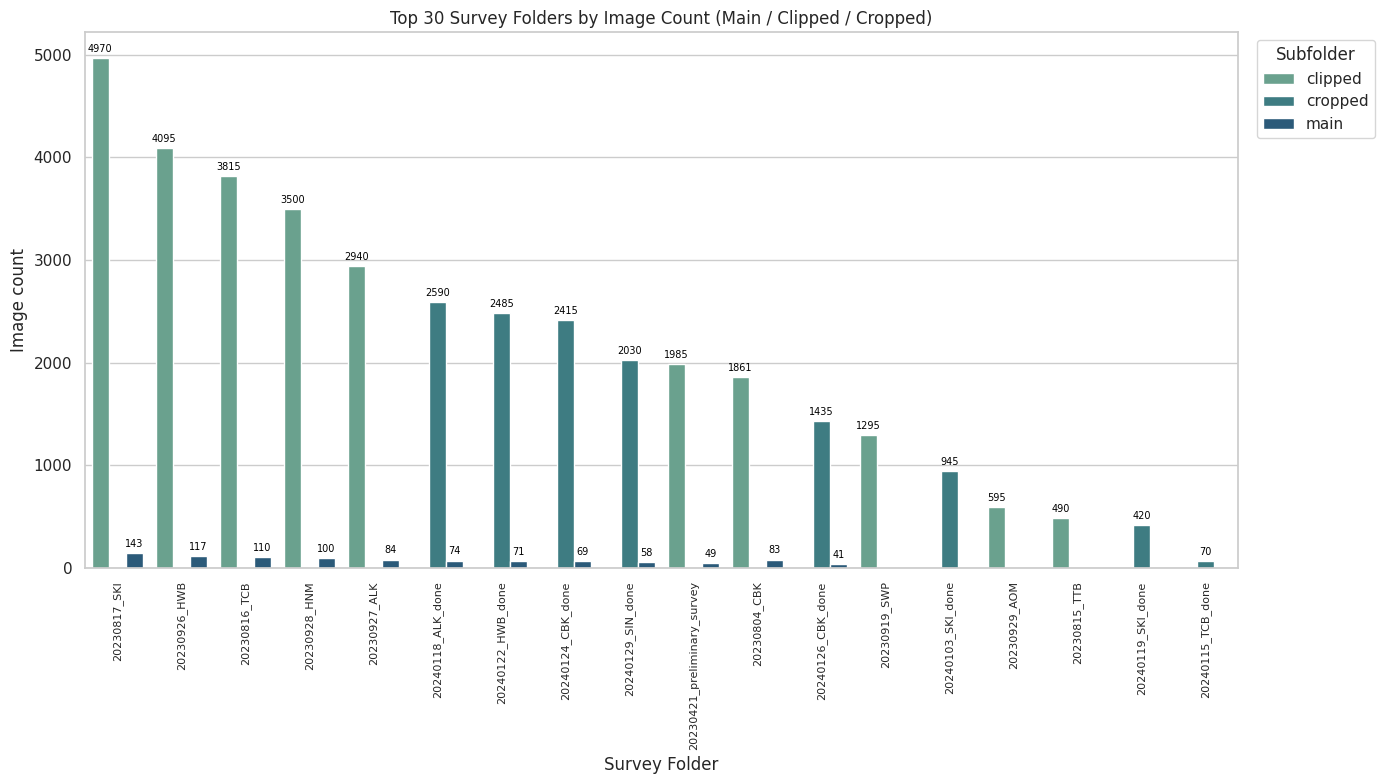

In [35]:
import seaborn as sns
sns.set(style="whitegrid")

meta_fp = '/kaggle/working/metadata.csv'

if Path(meta_fp).exists():
    df_meta = pd.read_csv(meta_fp)
    total_images = len(df_meta)
    n_folders = df_meta['folder'].nunique()
    print(f"Total images: {total_images}")
    print(f"Unique immediate folders: {n_folders}")

    # Extract survey folder and subfolder (e.g., clipped, cropped, or main)
    def extract_folders(path):
        parts = Path(path).parts
        if len(parts) >= 3 and parts[-2] in ['clipped', 'cropped']:
            return parts[-3], parts[-2]
        else:
            return parts[-2], 'main'

    df_meta[['survey_folder', 'subfolder']] = df_meta['image_path'].apply(
        lambda x: pd.Series(extract_folders(x))
    )

    # Group counts
    df_counts = (
        df_meta.groupby(['survey_folder', 'subfolder'])
        .size()
        .reset_index(name='count')
        .sort_values(by='count', ascending=False)
        .head(30)
    )

    # Plot
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(
        data=df_counts,
        x='survey_folder',
        y='count',
        hue='subfolder',
        palette='crest'
    )
    plt.xticks(rotation=90, fontsize=8)
    plt.title("Top 30 Survey Folders by Image Count (Main / Clipped / Cropped)")
    plt.ylabel("Image count")
    plt.xlabel("Survey Folder")

    # Add count labels on each bar (safely)
    for p in ax.patches:
        height = p.get_height()
        if not pd.isna(height) and height > 0:
            ax.annotate(
                f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=7, color='black', xytext=(0, 3),
                textcoords='offset points'
            )

    plt.legend(title='Subfolder', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('/kaggle/working/eda_folder_counts_with_clipped.png', dpi=200)
    plt.show()

else:
    print("metadata.csv not found. Please provide it to visualize folder distributions.")

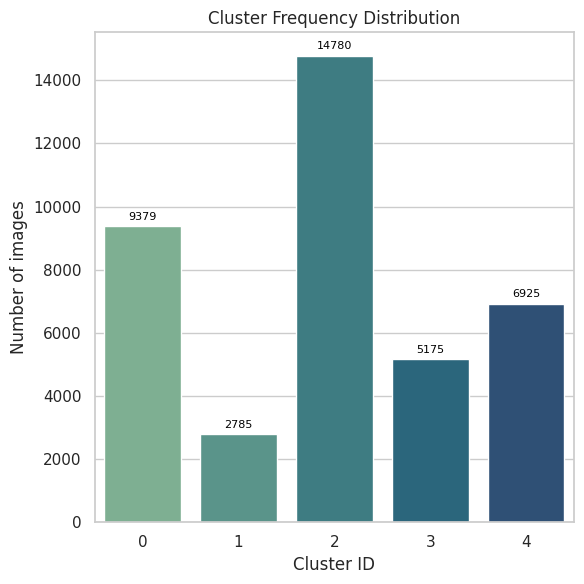

In [42]:
# Cluster size distribution
plt.figure(figsize=(6,6))
cluster_counts = df_clusters['cluster'].value_counts().sort_index()
ax = sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values, palette="crest")

plt.title("Cluster Frequency Distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of images")

# Add value labels on each bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=8, color='black', xytext=(0,3),
                    textcoords='offset points')

plt.tight_layout()
plt.savefig('/kaggle/working/eda_cluster_counts.png', dpi=200)
plt.show()

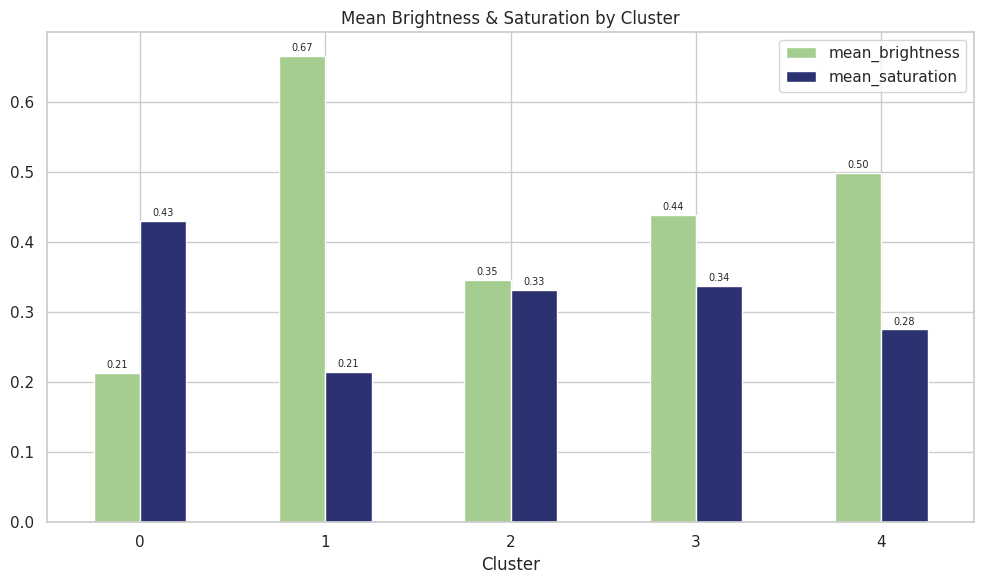

In [44]:
# Color/texture metrics per cluster
metrics_df = pd.read_csv('/kaggle/working/cluster_color_metrics.csv')
metrics_df = metrics_df.sort_values('cluster')

ax = metrics_df.plot(
    x='cluster', y=['mean_brightness', 'mean_saturation'], kind='bar',
    figsize=(10,6), title="Mean Brightness & Saturation by Cluster", colormap='crest'
)

plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.tight_layout()

# Add value labels for both bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=7, padding=2)

plt.savefig('/kaggle/working/eda_brightness_saturation_by_cluster.png', dpi=200)
plt.show()

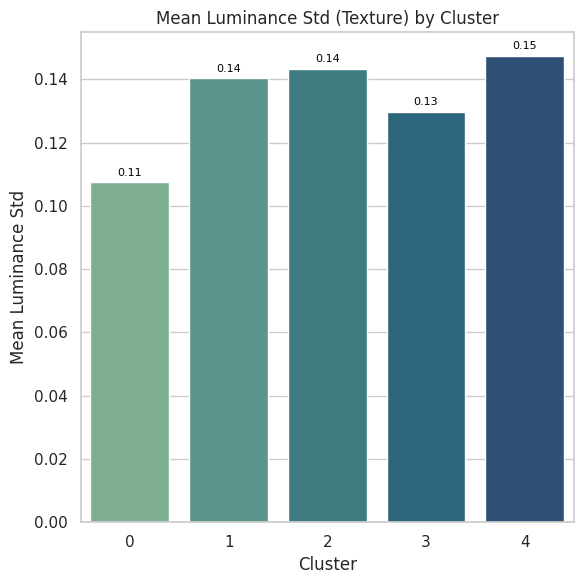

In [45]:
plt.figure(figsize=(6,6))
ax = sns.barplot(x='cluster', y='mean_luminance_std', data=metrics_df, palette='crest')
plt.title("Mean Luminance Std (Texture) by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Luminance Std")

# Add value labels on each bar
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=8, color='black', xytext=(0,3),
                    textcoords='offset points')

plt.tight_layout()
plt.savefig('/kaggle/working/eda_texture_by_cluster.png', dpi=200)
plt.show()

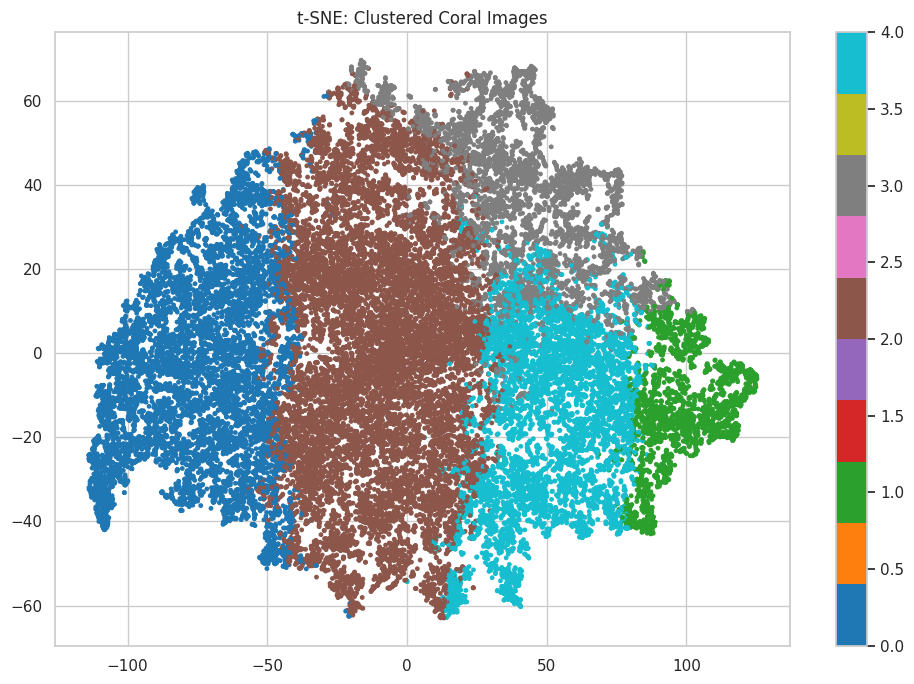

In [38]:
# t-SNE scatter with cluster coloring

# If you don't have tsne_results saved, compute for up to N points (or all if you want)
from sklearn.manifold import TSNE
import numpy as np

# choose limit if very large; but you said use all
X = np.load('/kaggle/working/coral_features.npy')  # or features_pca if saved
# If X is raw deep features, apply PCA first (you have features_pca earlier)
# For speed, reduce to 5000 if needed: X_vis = X if X.shape[0] <= 5000 else X[np.random.choice(X.shape[0], 5000, replace=False)]
X_vis = X
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(X_vis)
# Save for future
np.save('/kaggle/working/tsne_results.npy', tsne_results)

plt.figure(figsize=(10,7))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df_clusters['cluster'].astype(int), cmap='tab10', s=6)
plt.title('t-SNE: Clustered Coral Images')
plt.colorbar()
plt.tight_layout()
plt.savefig('/kaggle/working/eda_tsne_clusters.png', dpi=200)
plt.show()

***Representative Images per Cluster (Visual Interpretation):***

**What is this doing here?**  
For each cluster generated by K-Means, the code selects the **most representative image (medoid)** — the one whose deep features are closest to the cluster centroid.  
These representative images are then plotted side by side as a **montage**.

**Purpose of the same?**  
To visually inspect what each cluster “looks like” in terms of **color, brightness, and texture** and to validate that clustering actually captured meaningful visual differences rather than random groupings.

**Why are we doing this?**  
Because clustering is unsupervised, we need visual confirmation to interpret what patterns each group corresponds to — for example:
- Cluster 0: mid-tone corals under natural light  
- Cluster 1: bright, clear corals  
- Cluster 2: overexposed or bleached corals  
- Cluster 3: shadowed or muted tones  
- Cluster 4: dark, saturated corals or deeper environments  

This step transforms abstract feature-space clusters into **interpretable visual concepts** of coral health or habitat conditions.

---

***Cluster-Level Statistics (Source-Based Analysis):***

**What is this doing here?**  
This step computes **summary metrics per cluster** — such as mean brightness, mean saturation, and luminance variability (texture) — for all images belonging to each cluster. It also allows analyzing how clusters differ between **dry** and **wet** image sources.

**Purpose of the same?**  
To quantify visual differences across clusters and to understand whether certain clusters are dominated by specific conditions (e.g., wet underwater images being darker or less saturated).

**Why are we doing this?**  
It helps identify:
- Environmental patterns (e.g., dry corals appearing more vivid).  
- Lighting or acquisition biases in the dataset.  
- How natural variability aligns with unsupervised clusters.  

Such quantitative insights complement the visual interpretations, confirming whether clusters indeed separate based on physical or ecological differences.

---

***Folder-Level Image Distribution (Metadata-Based Analysis):***

**What is this doing here?**  
The `metadata.csv` was analyzed to count images per folder, revealing that folders like **“clipped”** and **“cropped”** dominate image counts.

**Purpose of the same?**  
To understand **data origin and preprocessing patterns** — why certain subsets have more images and whether this skews training balance.

**Why are we doing this?**  
Folders like “clipped” and “cropped” often result from **image preprocessing or augmentation**, where large coral photos are divided into tiles or cropped patches.  
This means the dataset has **many derived images from fewer unique locations**, creating an imbalance that must be managed in downstream modeling to avoid bias.

---

***Dataset Integrity and Readiness Validation:***

**What is this doing here?**  
This final analysis step combines the cluster, statistical, and metadata evaluations to ensure the dataset is **balanced, diverse, and consistent** before building the supervised model.

**Purpose of the same?**  
To validate that the dataset structure aligns with modeling goals — i.e., representing different coral health conditions, lighting variations, and acquisition environments fairly.

**Why are we doing this?**  
- To ensure **no artificial bias** dominates (e.g., cropped or dry images overwhelming natural samples).  
- To confirm **visual diversity** and feature stability across clusters.  
- To prepare for **multi-label supervised learning**, where coral health/stressor labels can be learned reliably.

Collectively, these steps verify dataset integrity, reveal structural imbalances, and establish a **scientifically interpretable foundation** for building classification and anomaly detection models on coral condition and stress.

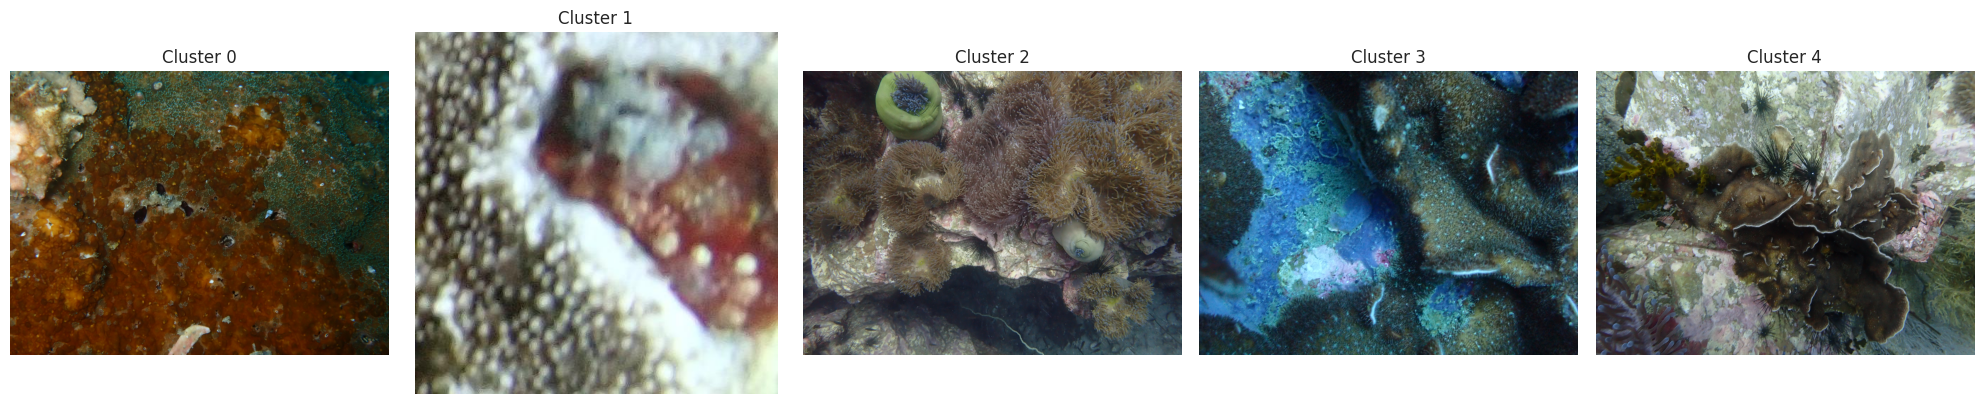

In [39]:
# Representative montage per cluster (central image) — pick cluster centroid image (most central)

from sklearn.metrics import pairwise_distances_argmin_min

# Load data
features = np.load('/kaggle/working/coral_features.npy')
df_clusters = pd.read_csv('/kaggle/working/coral_clusters.csv')
valid_paths = pd.read_csv('/kaggle/working/valid_paths.csv')['image_path'].tolist()

# Create dataframe linking image_path → feature index
df_features = pd.DataFrame({'image_path': valid_paths})
df_features['feat_index'] = df_features.index

# Merge to attach cluster to each feature index
df_merged = df_clusters.merge(df_features, on='image_path', how='inner')

sample_images = []

for c in sorted(df_merged['cluster'].unique()):
    cluster_group = df_merged[df_merged['cluster'] == c]
    feat_indices = cluster_group['feat_index'].values

    sub_feats = features[feat_indices]
    
    # Compute cluster medoid (most representative image)
    center = sub_feats.mean(axis=0, keepdims=True)
    _, min_idx = pairwise_distances_argmin_min(center, sub_feats)
    
    chosen_index = feat_indices[int(min_idx[0])]  # ensure integer
    chosen_path = valid_paths[chosen_index]
    
    sample_images.append((c, chosen_path))

# --- PLOT ---
plt.figure(figsize=(4 * len(sample_images), 4))

for i, (cluster_id, path) in enumerate(sample_images):
    img = Image.open(path).convert('RGB')
    plt.subplot(1, len(sample_images), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Cluster {cluster_id}", fontsize=12)

plt.tight_layout()
plt.savefig('/kaggle/working/eda_cluster_representatives.png', dpi=200)
plt.show()

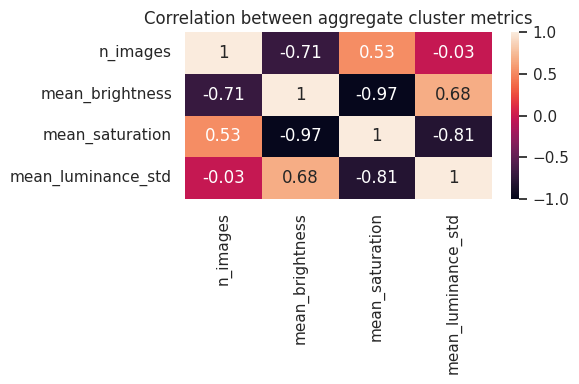

In [40]:
# Correlation matrix for numeric metrics

metrics_df = pd.read_csv('/kaggle/working/cluster_color_metrics.csv')
# If you have per-image metrics (not only per-cluster), compute correlation; otherwise use cluster-averages
# Suppose you saved per-image brightness/sat values earlier; else show correlations between cluster aggregate metrics:
plt.figure(figsize=(6,4))
sns.heatmap(metrics_df.set_index('cluster').corr(), annot=True, vmin=-1, vmax=1)
plt.title("Correlation between aggregate cluster metrics")
plt.tight_layout()
plt.savefig('/kaggle/working/eda_metrics_corr.png', dpi=200)
plt.show()

## Check for any missing values

In [52]:
# Assuming df is your main dataframe containing metadata + features
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if not missing_summary.empty:
    print("Missing Values Detected:")
    display(missing_summary)
else:
    print("No missing values detected in the dataset.")

No missing values detected in the dataset.


# Download all the files from Output (/kaggle/working)

In [46]:
!pwd

/kaggle/working


In [47]:
!zip -r eda_and_preprocessing_results.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/eda_cluster_representatives.png (deflated 0%)
  adding: kaggle/working/metadata.csv (deflated 96%)
  adding: kaggle/working/coral_features.npy (deflated 7%)
  adding: kaggle/working/valid_paths.csv (deflated 97%)
  adding: kaggle/working/eda_metrics_corr.png (deflated 10%)
  adding: kaggle/working/eda_brightness_saturation_by_cluster.png (deflated 27%)
  adding: kaggle/working/eda_cluster_counts.png (deflated 25%)
  adding: kaggle/working/eda_texture_by_cluster.png (deflated 24%)
  adding: kaggle/working/eda_folder_counts_with_clipped.png (deflated 23%)
  adding: kaggle/working/tsne_results.npy (deflated 8%)
  adding: kaggle/working/cluster_color_metrics.csv (deflated 40%)
  adding: kaggle/working/eda_folder_counts.png (deflated 18%)
  adding: kaggle/working/coral_clusters.csv (deflated 97%)
  adding: kaggle/working/eda_tsne_clusters.png (deflated 2%)


In [48]:
!ls -lrth

total 395M
-rw-r--r-- 1 root root 6.4M Nov  9 16:46 metadata.csv
-rw-r--r-- 1 root root 191M Nov  9 17:11 coral_features.npy
-rw-r--r-- 1 root root 4.7M Nov  9 17:11 valid_paths.csv
-rw-r--r-- 1 root root 4.8M Nov  9 17:11 coral_clusters.csv
-rw-r--r-- 1 root root  395 Nov  9 17:39 cluster_color_metrics.csv
-rw-r--r-- 1 root root 111K Nov  9 17:42 eda_folder_counts.png
-rw-r--r-- 1 root root 173K Nov  9 17:46 eda_folder_counts_with_clipped.png
-rw-r--r-- 1 root root 306K Nov  9 17:53 tsne_results.npy
-rw-r--r-- 1 root root 757K Nov  9 17:53 eda_tsne_clusters.png
-rw-r--r-- 1 root root 4.1M Nov  9 17:53 eda_cluster_representatives.png
-rw-r--r-- 1 root root  90K Nov  9 17:53 eda_metrics_corr.png
-rw-r--r-- 1 root root  60K Nov  9 17:56 eda_cluster_counts.png
-rw-r--r-- 1 root root  63K Nov  9 17:56 eda_brightness_saturation_by_cluster.png
-rw-r--r-- 1 root root  53K Nov  9 17:57 eda_texture_by_cluster.png
-rw-r--r-- 1 root root 183M Nov  9 17:59 eda_and_preprocessing_results.zip


In [51]:
from IPython.display import FileLink
FileLink(r'eda_and_preprocessing_results.zip')

/kaggle/working/eda_and_preprocessing_results.zip